# Federated Learning for Brain Tumor Detection
## Using FedAvg Algorithm with VGG16 and DenseNet Models

## 1. Setup and Dependencies

In [1]:
# Patch for deprecated np.bool in recent NumPy versions
import numpy as np
if not hasattr(np, 'bool'):
    np.bool = bool  # For compatibility with code/libraries using np.bool

/tmp/ipykernel_67/4043859576.py:3: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from skimage import filters, segmentation, measure
from skimage.morphology import closing, square
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

2025-09-16 06:00:17.661411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758002418.018070      67 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758002418.129926      67 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## 2. Data Setup and Configuration

In [3]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS_PER_ROUND = 10
FEDERATED_ROUNDS = 5
NUM_CLIENTS = 5
LEARNING_RATE = 0.001

# Class names
CLASS_NAMES = ['Glioma', 'Meningioma', 'Notumor', 'Pituitary']
NUM_CLASSES = len(CLASS_NAMES)

# Data paths for Kaggle environment
# Place your dataset in /kaggle/input/brain-tumor-dataset/ (or update the path below)
BASE_PATH = '/kaggle/input/flbrain/FLBrain'  # Change this to your Kaggle dataset path
CLIENT_PATHS = [f'{BASE_PATH}/client{i+1}' for i in range(NUM_CLIENTS)]

print(f"Configuration:")
print(f"- Image Size: {IMG_SIZE}")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Epochs per Round: {EPOCHS_PER_ROUND}")
print(f"- Federated Rounds: {FEDERATED_ROUNDS}")
print(f"- Number of Clients: {NUM_CLIENTS}")
print(f"- Classes: {CLASS_NAMES}")

Configuration:
- Image Size: (224, 224)
- Batch Size: 16
- Epochs per Round: 10
- Federated Rounds: 5
- Number of Clients: 5
- Classes: ['Glioma', 'Meningioma', 'Notumor', 'Pituitary']


## 3. Data Loading and Preprocessing Functions

In [4]:
def load_client_data(client_path, img_size=IMG_SIZE):
    """
    Load data for a specific client
    """
    images = []
    labels = []

    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(client_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Path {class_path} does not exist")
            continue

        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, img_file)
                try:
                    # Load and preprocess image
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size)
                    img = img.astype(np.float32) / 255.0

                    images.append(img)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

def preprocess_image_for_analysis(image):
    """
    Apply various image processing techniques for analysis
    """
    # Convert to grayscale
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Edge detection
    edges = cv2.Canny(gray, 50, 150)

    return {
        'original': image,
        'grayscale': gray,
        'binary': binary,
        'processed': processed,
        'edges': edges
    }

def detect_tumor_region(image):
    """
    Simple tumor region detection using image processing
    """
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Apply threshold
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create mask for largest contour (potential tumor)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(gray)
        cv2.fillPoly(mask, [largest_contour], 255)

        # Apply mask to original image
        result = image.copy()
        result[mask == 0] = 0

        return result, mask

    return image, np.zeros_like(gray)

## 4. Model Definitions

In [5]:
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=4):
    """
    Create VGG16-based model for brain tumor classification
    """
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze base model layers
    base_model.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_densenet_model(input_shape=(224, 224, 3), num_classes=4):
    """
    Create DenseNet121-based model for brain tumor classification
    """
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze base model layers
    base_model.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Test model creation
print("Testing model creation...")
test_vgg = create_vgg16_model()
test_densenet = create_densenet_model()
print(f"VGG16 model parameters: {test_vgg.count_params():,}")
print(f"DenseNet model parameters: {test_densenet.count_params():,}")

Testing model creation...


I0000 00:00:1758002434.859417      67 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758002434.860194      67 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 model parameters: 15,109,700
DenseNet model parameters: 7,694,660


## 5. Federated Averaging (FedAvg) Implementation

In [6]:
class FederatedLearning:
    def __init__(self, model_creator, num_clients=5):
        self.model_creator = model_creator
        self.num_clients = num_clients
        self.global_model = model_creator()
        self.client_models = [model_creator() for _ in range(num_clients)]
        self.client_data = {}
        self.client_histories = {}

    def load_client_datasets(self, client_paths):
        """
        Load datasets for all clients
        """
        for i, client_path in enumerate(client_paths):
            print(f"Loading data for Client {i+1}...")
            X, y = load_client_data(client_path)

            if len(X) > 0:
                # Split into train and test
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=42, stratify=y
                )

                # Convert labels to categorical
                y_train_cat = to_categorical(y_train, NUM_CLASSES)
                y_test_cat = to_categorical(y_test, NUM_CLASSES)

                self.client_data[i] = {
                    'X_train': X_train,
                    'X_test': X_test,
                    'y_train': y_train_cat,
                    'y_test': y_test_cat,
                    'y_train_raw': y_train,
                    'y_test_raw': y_test
                }

                print(f"Client {i+1}: {len(X_train)} training, {len(X_test)} testing samples")
            else:
                print(f"Warning: No data found for Client {i+1}")

    def federated_averaging(self, client_weights):
        """
        Perform federated averaging of client model weights
        """
        # Get the structure from the first client
        avg_weights = []

        # Initialize with zeros
        for layer_weights in client_weights[0]:
            avg_weights.append(np.zeros_like(layer_weights))

        # Average the weights
        for client_weight in client_weights:
            for i, layer_weights in enumerate(client_weight):
                avg_weights[i] += layer_weights / len(client_weights)

        return avg_weights

    def train_round(self, round_num):
        """
        Execute one round of federated training
        """
        print(f"\n=== Federated Round {round_num + 1} ===")

        client_weights = []

        for client_id in range(self.num_clients):
            if client_id not in self.client_data:
                continue

            print(f"Training Client {client_id + 1}...")

            # Set global weights to client model
            self.client_models[client_id].set_weights(self.global_model.get_weights())

            # Train client model
            data = self.client_data[client_id]
            history = self.client_models[client_id].fit(
                data['X_train'], data['y_train'],
                batch_size=BATCH_SIZE,
                epochs=EPOCHS_PER_ROUND,
                validation_data=(data['X_test'], data['y_test']),
                verbose=0
            )

            # Store training history
            if client_id not in self.client_histories:
                self.client_histories[client_id] = []
            self.client_histories[client_id].append(history.history)

            # Collect client weights
            client_weights.append(self.client_models[client_id].get_weights())

            # Print client performance
            final_acc = history.history['accuracy'][-1]
            final_val_acc = history.history['val_accuracy'][-1]
            print(f"Client {client_id + 1} - Accuracy: {final_acc:.4f}, Val Accuracy: {final_val_acc:.4f}")

        # Perform federated averaging
        if client_weights:
            avg_weights = self.federated_averaging(client_weights)
            self.global_model.set_weights(avg_weights)
            print("Global model updated with federated averaging")

    def evaluate_clients(self):
        """
        Evaluate all clients and generate reports
        """
        results = {}

        for client_id in range(self.num_clients):
            if client_id not in self.client_data:
                continue

            data = self.client_data[client_id]

            # Set global weights to client model for evaluation
            self.client_models[client_id].set_weights(self.global_model.get_weights())

            # Make predictions
            y_pred_prob = self.client_models[client_id].predict(data['X_test'], verbose=0)
            y_pred = np.argmax(y_pred_prob, axis=1)
            y_true = data['y_test_raw']

            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            conf_matrix = confusion_matrix(y_true, y_pred)
            class_report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)

            results[client_id] = {
                'accuracy': accuracy,
                'confusion_matrix': conf_matrix,
                'classification_report': class_report,
                'y_true': y_true,
                'y_pred': y_pred,
                'test_images': data['X_test']
            }

            print(f"\nClient {client_id + 1} Final Accuracy: {accuracy:.4f}")

        return results

## 6. Data Upload (For Kaggle)

**Note:** In Kaggle, upload your dataset via the 'Add Data' button and reference it using the /kaggle/input/ path.
Ensure your client folders are structured as: /kaggle/input/brain-tumor-dataset/client1/Glioma/, etc.

In [7]:
# Kaggle does not require mounting drives. Just use the /kaggle/input/ path for your data.
# Example: BASE_PATH = '/kaggle/input/brain-tumor-dataset'

## 7. Training with VGG16 Model

In [8]:
# Initialize Federated Learning with VGG16
print("Initializing Federated Learning with VGG16...")
fl_vgg16 = FederatedLearning(create_vgg16_model, NUM_CLIENTS)

# Load client datasets
fl_vgg16.load_client_datasets(CLIENT_PATHS)

# Check if data was loaded successfully
if not fl_vgg16.client_data:
    print("\nWarning: No client data loaded. Please check your data paths.")
    print("Current CLIENT_PATHS:", CLIENT_PATHS)
    print("\nIf running on Google Colab, make sure to:")
    print("1. Upload your client datasets")
    print("2. Update the BASE_PATH variable")
    print("3. Ensure the directory structure matches: client1/Glioma/, client1/Meningioma/, etc.")
else:
    # Train federated model
    print(f"\nStarting federated training with VGG16 for {FEDERATED_ROUNDS} rounds...")
    for round_num in range(FEDERATED_ROUNDS):
        fl_vgg16.train_round(round_num)

    print("\nVGG16 Federated training completed!")

Initializing Federated Learning with VGG16...
Loading data for Client 1...
Client 1: 915 training, 229 testing samples
Loading data for Client 2...
Client 2: 914 training, 229 testing samples
Loading data for Client 3...
Client 3: 913 training, 229 testing samples
Loading data for Client 4...
Client 4: 913 training, 229 testing samples
Loading data for Client 5...
Client 5: 912 training, 229 testing samples

Starting federated training with VGG16 for 5 rounds...

=== Federated Round 1 ===
Training Client 1...


I0000 00:00:1758002537.358870     105 service.cc:148] XLA service 0x7a4e38011540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758002537.360297     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758002537.360315     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758002537.854807     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758002546.685995     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Client 1 - Accuracy: 0.8350, Val Accuracy: 0.8603
Training Client 2...
Client 2 - Accuracy: 0.8556, Val Accuracy: 0.8646
Training Client 3...
Client 3 - Accuracy: 0.8565, Val Accuracy: 0.8341
Training Client 4...
Client 4 - Accuracy: 0.8401, Val Accuracy: 0.8515
Training Client 5...
Client 5 - Accuracy: 0.8399, Val Accuracy: 0.8996
Global model updated with federated averaging

=== Federated Round 2 ===
Training Client 1...
Client 1 - Accuracy: 0.8328, Val Accuracy: 0.8646
Training Client 2...
Client 2 - Accuracy: 0.8621, Val Accuracy: 0.8603
Training Client 3...
Client 3 - Accuracy: 0.8631, Val Accuracy: 0.8472
Training Client 4...
Client 4 - Accuracy: 0.8675, Val Accuracy: 0.8384
Training Client 5...
Client 5 - Accuracy: 0.8553, Val Accuracy: 0.8603
Global model updated with federated averaging

=== Federated Round 3 ===
Training Client 1...
Client 1 - Accuracy: 0.8721, Val Accuracy: 0.8384
Training Client 2...
Client 2 - Accuracy: 0.8731, Val Accuracy: 0.8734
Training Client 3...
Cl

## 8. Training with DenseNet Model

In [9]:
# Initialize Federated Learning with DenseNet
print("Initializing Federated Learning with DenseNet...")
fl_densenet = FederatedLearning(create_densenet_model, NUM_CLIENTS)

# Load client datasets
fl_densenet.load_client_datasets(CLIENT_PATHS)

if fl_densenet.client_data:
    # Train federated model
    print(f"\nStarting federated training with DenseNet for {FEDERATED_ROUNDS} rounds...")
    for round_num in range(FEDERATED_ROUNDS):
        fl_densenet.train_round(round_num)

    print("\nDenseNet Federated training completed!")
else:
    print("Skipping DenseNet training - no data loaded")

Initializing Federated Learning with DenseNet...
Loading data for Client 1...
Client 1: 915 training, 229 testing samples
Loading data for Client 2...
Client 2: 914 training, 229 testing samples
Loading data for Client 3...
Client 3: 913 training, 229 testing samples
Loading data for Client 4...
Client 4: 913 training, 229 testing samples
Loading data for Client 5...
Client 5: 912 training, 229 testing samples

Starting federated training with DenseNet for 5 rounds...

=== Federated Round 1 ===
Training Client 1...
Client 1 - Accuracy: 0.8874, Val Accuracy: 0.8646
Training Client 2...
Client 2 - Accuracy: 0.9037, Val Accuracy: 0.8996
Training Client 3...
Client 3 - Accuracy: 0.8883, Val Accuracy: 0.8428
Training Client 4...
Client 4 - Accuracy: 0.8686, Val Accuracy: 0.8952
Training Client 5...
Client 5 - Accuracy: 0.8882, Val Accuracy: 0.9170
Global model updated with federated averaging

=== Federated Round 2 ===
Training Client 1...
Client 1 - Accuracy: 0.8896, Val Accuracy: 0.8952
T

## 9. Model Evaluation and Results


VGG16 MODEL EVALUATION RESULTS

Client 1 Final Accuracy: 0.8908

Client 2 Final Accuracy: 0.8777

Client 3 Final Accuracy: 0.8428

Client 4 Final Accuracy: 0.9258

Client 5 Final Accuracy: 0.9127

--- Client 1 Results ---


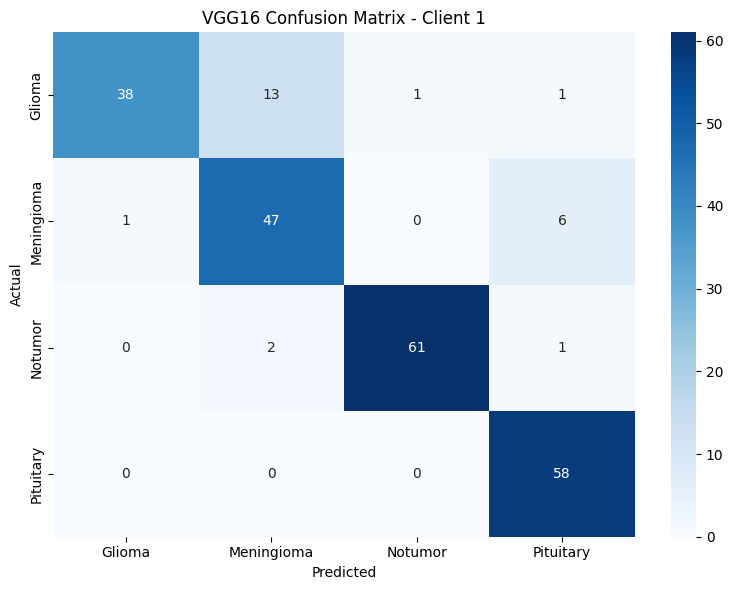


VGG16 - Client 1 Classification Report:
              precision  recall  f1-score   support
Glioma           0.9744  0.7170    0.8261   53.0000
Meningioma       0.7581  0.8704    0.8103   54.0000
Notumor          0.9839  0.9531    0.9683   64.0000
Pituitary        0.8788  1.0000    0.9355   58.0000
accuracy         0.8908  0.8908    0.8908    0.8908
macro avg        0.8988  0.8851    0.8850  229.0000
weighted avg     0.9018  0.8908    0.8898  229.0000

--- Client 2 Results ---


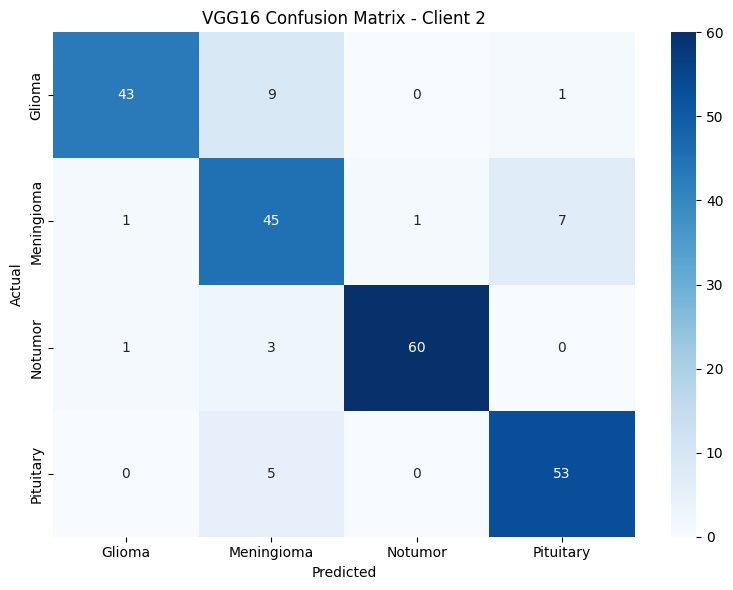


VGG16 - Client 2 Classification Report:
              precision  recall  f1-score   support
Glioma           0.9556  0.8113    0.8776   53.0000
Meningioma       0.7258  0.8333    0.7759   54.0000
Notumor          0.9836  0.9375    0.9600   64.0000
Pituitary        0.8689  0.9138    0.8908   58.0000
accuracy         0.8777  0.8777    0.8777    0.8777
macro avg        0.8835  0.8740    0.8760  229.0000
weighted avg     0.8873  0.8777    0.8800  229.0000

--- Client 3 Results ---


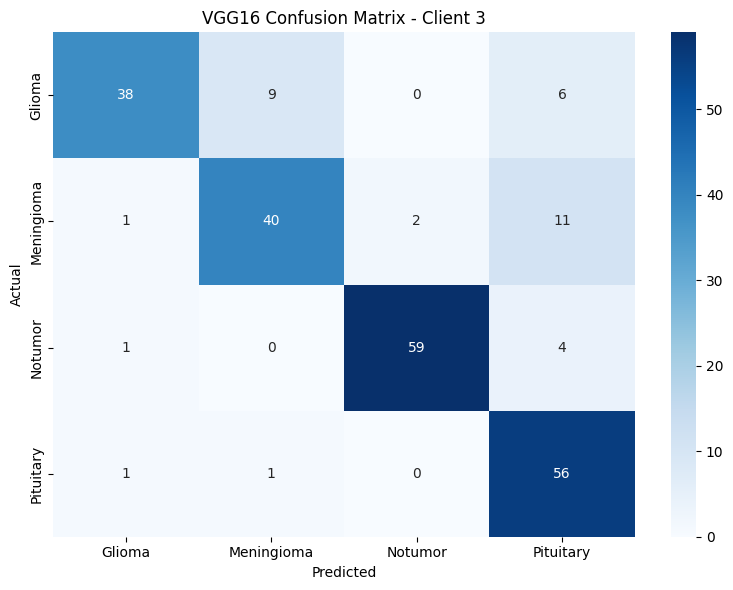


VGG16 - Client 3 Classification Report:
              precision  recall  f1-score   support
Glioma           0.9268  0.7170    0.8085   53.0000
Meningioma       0.8000  0.7407    0.7692   54.0000
Notumor          0.9672  0.9219    0.9440   64.0000
Pituitary        0.7273  0.9655    0.8296   58.0000
accuracy         0.8428  0.8428    0.8428    0.8428
macro avg        0.8553  0.8363    0.8378  229.0000
weighted avg     0.8577  0.8428    0.8425  229.0000

--- Client 4 Results ---


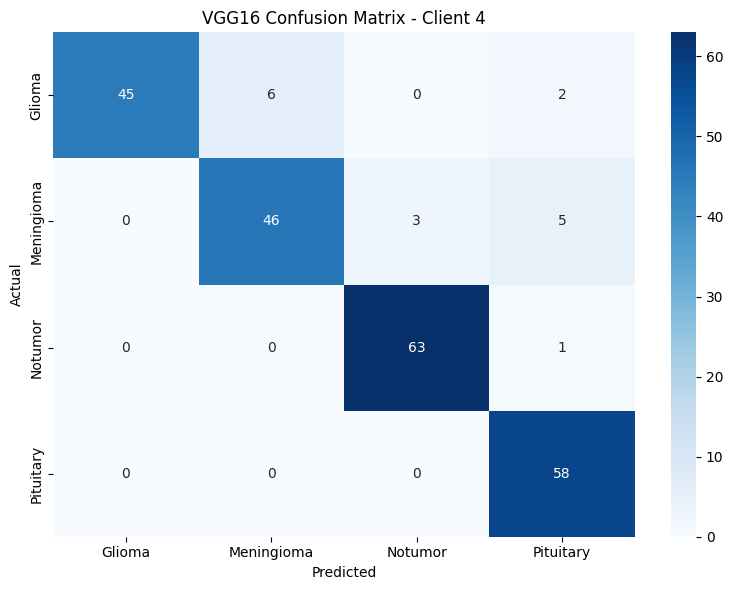


VGG16 - Client 4 Classification Report:
              precision  recall  f1-score   support
Glioma           1.0000  0.8491    0.9184   53.0000
Meningioma       0.8846  0.8519    0.8679   54.0000
Notumor          0.9545  0.9844    0.9692   64.0000
Pituitary        0.8788  1.0000    0.9355   58.0000
accuracy         0.9258  0.9258    0.9258    0.9258
macro avg        0.9295  0.9213    0.9228  229.0000
weighted avg     0.9294  0.9258    0.9250  229.0000

--- Client 5 Results ---


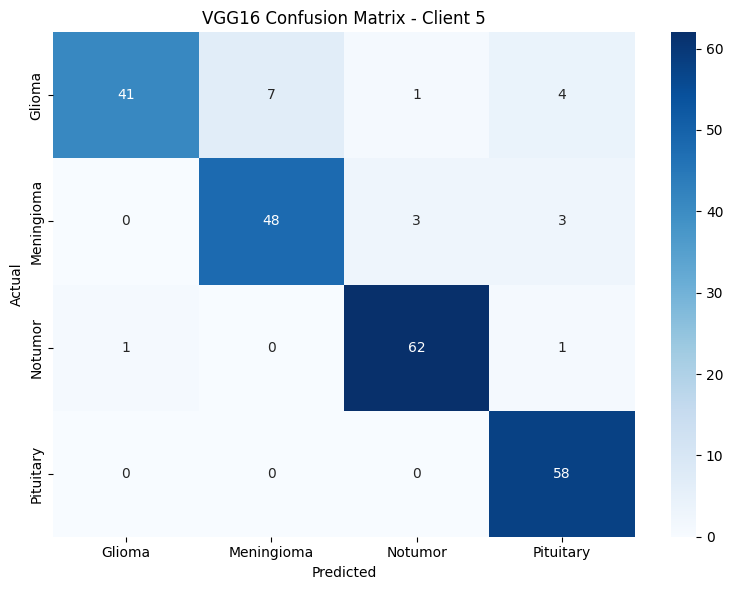


VGG16 - Client 5 Classification Report:
              precision  recall  f1-score   support
Glioma           0.9762  0.7736    0.8632   53.0000
Meningioma       0.8727  0.8889    0.8807   54.0000
Notumor          0.9394  0.9688    0.9538   64.0000
Pituitary        0.8788  1.0000    0.9355   58.0000
accuracy         0.9127  0.9127    0.9127    0.9127
macro avg        0.9168  0.9078    0.9083  229.0000
weighted avg     0.9168  0.9127    0.9110  229.0000

DENSENET MODEL EVALUATION RESULTS

Client 1 Final Accuracy: 0.9039

Client 2 Final Accuracy: 0.9039

Client 3 Final Accuracy: 0.8865

Client 4 Final Accuracy: 0.9345

Client 5 Final Accuracy: 0.9170

--- Client 1 Results ---


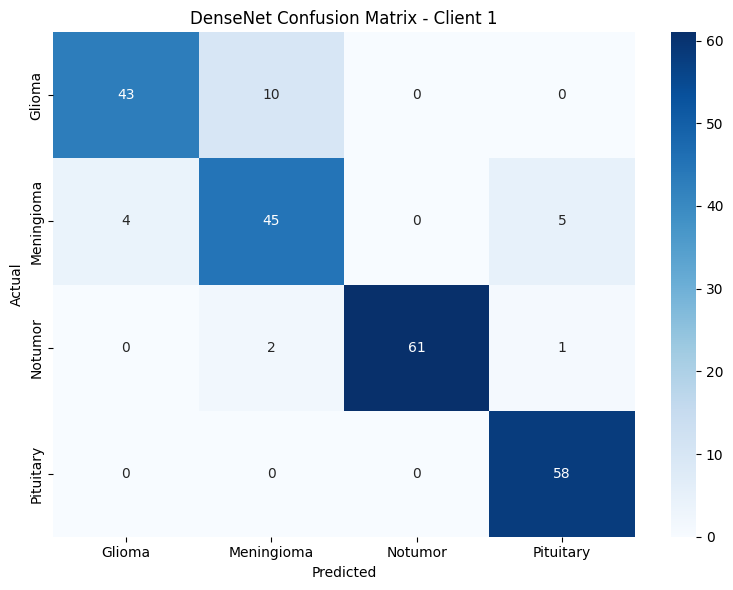


DenseNet - Client 1 Classification Report:
              precision  recall  f1-score   support
Glioma           0.9149  0.8113    0.8600   53.0000
Meningioma       0.7895  0.8333    0.8108   54.0000
Notumor          1.0000  0.9531    0.9760   64.0000
Pituitary        0.9062  1.0000    0.9508   58.0000
accuracy         0.9039  0.9039    0.9039    0.9039
macro avg        0.9027  0.8994    0.8994  229.0000
weighted avg     0.9069  0.9039    0.9038  229.0000

--- Client 2 Results ---


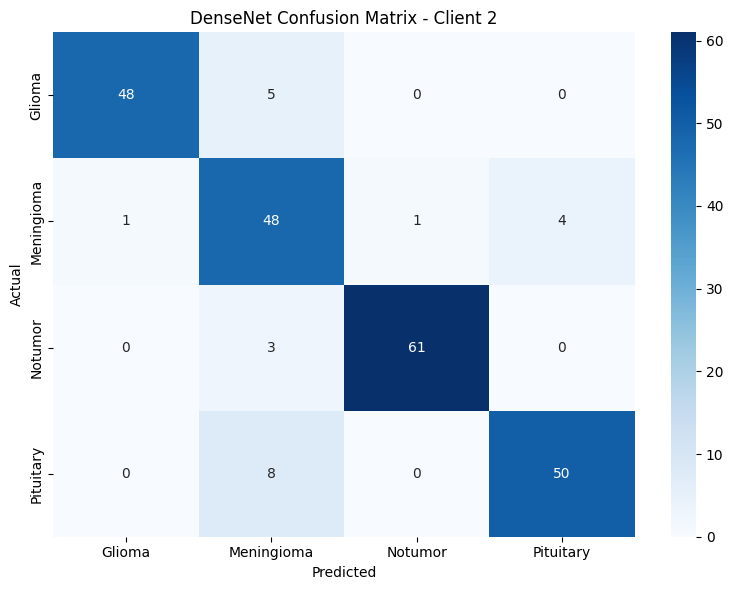


DenseNet - Client 2 Classification Report:
              precision  recall  f1-score   support
Glioma           0.9796  0.9057    0.9412   53.0000
Meningioma       0.7500  0.8889    0.8136   54.0000
Notumor          0.9839  0.9531    0.9683   64.0000
Pituitary        0.9259  0.8621    0.8929   58.0000
accuracy         0.9039  0.9039    0.9039    0.9039
macro avg        0.9098  0.9024    0.9040  229.0000
weighted avg     0.9131  0.9039    0.9064  229.0000

--- Client 3 Results ---


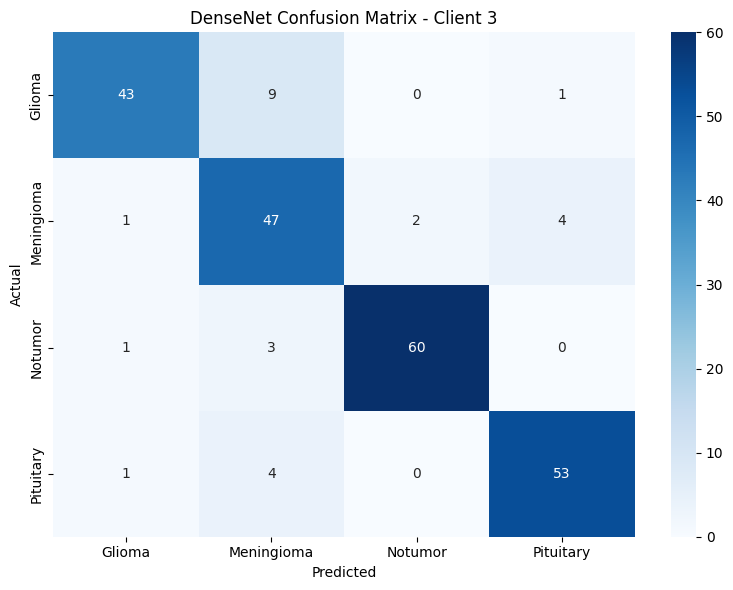


DenseNet - Client 3 Classification Report:
              precision  recall  f1-score   support
Glioma           0.9348  0.8113    0.8687   53.0000
Meningioma       0.7460  0.8704    0.8034   54.0000
Notumor          0.9677  0.9375    0.9524   64.0000
Pituitary        0.9138  0.9138    0.9138   58.0000
accuracy         0.8865  0.8865    0.8865    0.8865
macro avg        0.8906  0.8832    0.8846  229.0000
weighted avg     0.8942  0.8865    0.8881  229.0000

--- Client 4 Results ---


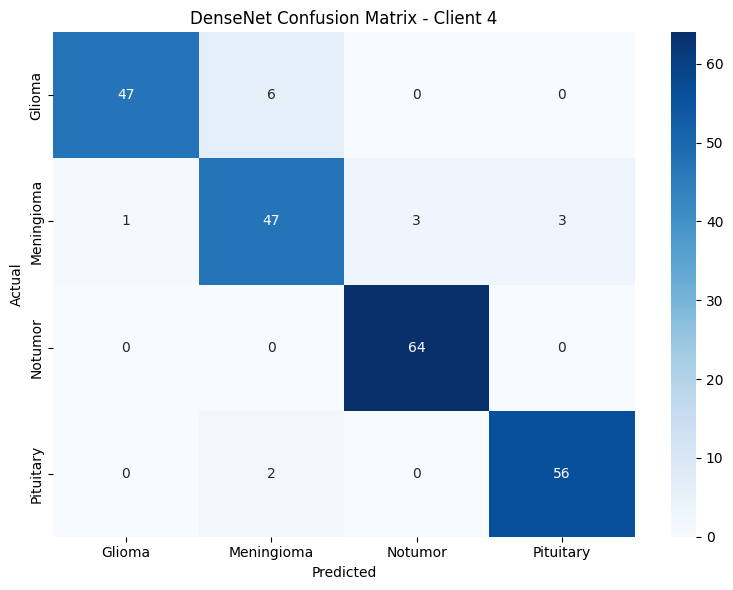


DenseNet - Client 4 Classification Report:
              precision  recall  f1-score   support
Glioma           0.9792  0.8868    0.9307   53.0000
Meningioma       0.8545  0.8704    0.8624   54.0000
Notumor          0.9552  1.0000    0.9771   64.0000
Pituitary        0.9492  0.9655    0.9573   58.0000
accuracy         0.9345  0.9345    0.9345    0.9345
macro avg        0.9345  0.9307    0.9319  229.0000
weighted avg     0.9355  0.9345    0.9343  229.0000

--- Client 5 Results ---


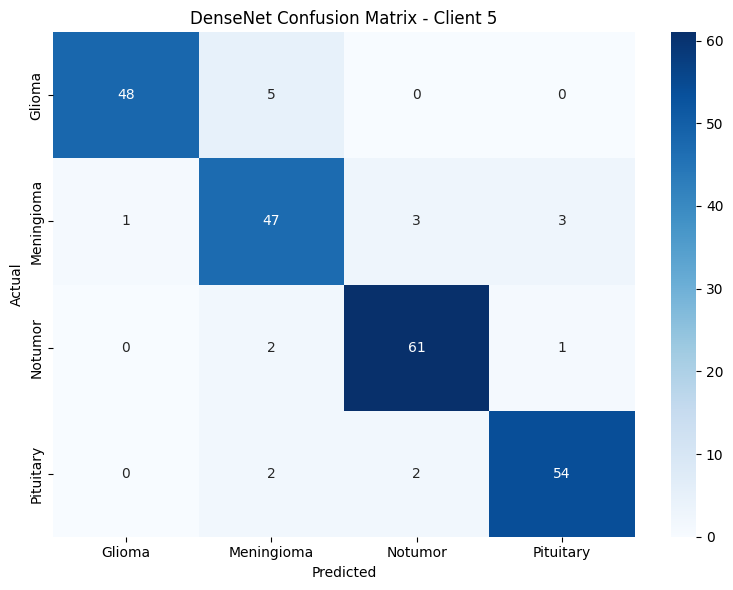


DenseNet - Client 5 Classification Report:
              precision  recall  f1-score  support
Glioma           0.9796  0.9057    0.9412   53.000
Meningioma       0.8393  0.8704    0.8545   54.000
Notumor          0.9242  0.9531    0.9385   64.000
Pituitary        0.9310  0.9310    0.9310   58.000
accuracy         0.9170  0.9170    0.9170    0.917
macro avg        0.9185  0.9150    0.9163  229.000
weighted avg     0.9187  0.9170    0.9174  229.000


In [10]:
def plot_confusion_matrix(cm, class_names, title, client_id):
    """
    Plot confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title} - Client {client_id + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

def display_classification_report(report, title, client_id):
    """
    Display classification report as a formatted table
    """
    print(f"\n{title} - Client {client_id + 1} Classification Report:")
    print("=" * 60)

    # Create DataFrame for better formatting
    df_report = pd.DataFrame(report).transpose()
    df_report = df_report.round(4)
    print(df_report)

# Evaluate VGG16 model
if fl_vgg16.client_data:
    print("\n" + "="*50)
    print("VGG16 MODEL EVALUATION RESULTS")
    print("="*50)

    vgg16_results = fl_vgg16.evaluate_clients()

    for client_id, results in vgg16_results.items():
        print(f"\n--- Client {client_id + 1} Results ---")

        # Plot confusion matrix
        plot_confusion_matrix(results['confusion_matrix'], CLASS_NAMES,
                            'VGG16 Confusion Matrix', client_id)

        # Display classification report
        display_classification_report(results['classification_report'],
                                    'VGG16', client_id)

# Evaluate DenseNet model
if fl_densenet.client_data:
    print("\n" + "="*50)
    print("DENSENET MODEL EVALUATION RESULTS")
    print("="*50)

    densenet_results = fl_densenet.evaluate_clients()

    for client_id, results in densenet_results.items():
        print(f"\n--- Client {client_id + 1} Results ---")

        # Plot confusion matrix
        plot_confusion_matrix(results['confusion_matrix'], CLASS_NAMES,
                            'DenseNet Confusion Matrix', client_id)

        # Display classification report
        display_classification_report(results['classification_report'],
                                    'DenseNet', client_id)

## 10. Image Processing and Tumor Detection Visualization

In [11]:
'''
def visualize_image_processing(image, title="Image Processing Steps"):
    """
    Visualize different image processing steps
    """
    processed = preprocess_image_for_analysis(image)
    tumor_region, tumor_mask = detect_tumor_region(image)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    # Original image
    axes[0, 0].imshow(processed['original'])
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # Grayscale
    axes[0, 1].imshow(processed['grayscale'], cmap='gray')
    axes[0, 1].set_title('Grayscale')
    axes[0, 1].axis('off')

    # Binary/Thresholded
    axes[0, 2].imshow(processed['binary'], cmap='gray')
    axes[0, 2].set_title('Binary (Thresholded)')
    axes[0, 2].axis('off')

    # Morphological processing
    axes[1, 0].imshow(processed['processed'], cmap='gray')
    axes[1, 0].set_title('Morphological Processing')
    axes[1, 0].axis('off')

    # Edge detection
    axes[1, 1].imshow(processed['edges'], cmap='gray')
    axes[1, 1].set_title('Edge Detection')
    axes[1, 1].axis('off')

    # Tumor region detection
    axes[1, 2].imshow(tumor_region)
    axes[1, 2].set_title('Detected Tumor Region')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

def demonstrate_image_processing_per_client():
    """
    Demonstrate image processing for each client
    """
    if fl_vgg16.client_data:
        for client_id in fl_vgg16.client_data.keys():
            data = fl_vgg16.client_data[client_id]

            # Select a few random test images from each client
            num_samples = min(3, len(data['X_test']))
            sample_indices = np.random.choice(len(data['X_test']), num_samples, replace=False)

            print(f"\n{'='*60}")
            print(f"CLIENT {client_id + 1} - IMAGE PROCESSING DEMONSTRATION")
            print(f"{'='*60}")

            for i, idx in enumerate(sample_indices):
                image = data['X_test'][idx]
                true_label = CLASS_NAMES[data['y_test_raw'][idx]]

                title = f"Client {client_id + 1} - Sample {i+1} (True: {true_label})"
                visualize_image_processing(image, title)
    else:
        print("No client data available for image processing demonstration")

# Run image processing demonstration
demonstrate_image_processing_per_client()
'''

'\ndef visualize_image_processing(image, title="Image Processing Steps"):\n    """\n    Visualize different image processing steps\n    """\n    processed = preprocess_image_for_analysis(image)\n    tumor_region, tumor_mask = detect_tumor_region(image)\n\n    fig, axes = plt.subplots(2, 3, figsize=(15, 10))\n    fig.suptitle(title, fontsize=16)\n\n    # Original image\n    axes[0, 0].imshow(processed[\'original\'])\n    axes[0, 0].set_title(\'Original Image\')\n    axes[0, 0].axis(\'off\')\n\n    # Grayscale\n    axes[0, 1].imshow(processed[\'grayscale\'], cmap=\'gray\')\n    axes[0, 1].set_title(\'Grayscale\')\n    axes[0, 1].axis(\'off\')\n\n    # Binary/Thresholded\n    axes[0, 2].imshow(processed[\'binary\'], cmap=\'gray\')\n    axes[0, 2].set_title(\'Binary (Thresholded)\')\n    axes[0, 2].axis(\'off\')\n\n    # Morphological processing\n    axes[1, 0].imshow(processed[\'processed\'], cmap=\'gray\')\n    axes[1, 0].set_title(\'Morphological Processing\')\n    axes[1, 0].axis(\'off

In [12]:
# --- Improved User-Driven Image Selection and Tumor Type Display with Red Overlay and Area-Based Stage Calculation (Closure Fix, Partial Binding) ---
import ipywidgets as widgets
from IPython.display import display, clear_output
from functools import partial

def user_select_and_visualize_image_per_client():
    if not fl_vgg16.client_data:
        print("No client data available for image selection.")
        return

    def calculate_tumor_stage(mask):
        area = mask.sum() / 255
        total = mask.size
        percent = area / total * 100
        print(percent)
        if percent < 35:
            return 'Stage I'
        elif percent < 60:
            return 'Stage II'
        else:
            return 'Stage III'

    for client_id, data in fl_vgg16.client_data.items():
        print(f"\n{'='*60}")
        print(f"CLIENT {client_id + 1} - SELECT AN IMAGE FOR ANALYSIS")
        print(f"{'='*60}")

        if len(data['X_test']) == 0:
            print("No test images available for this client.")
            continue

        options = [(f"Index {i} (True: {CLASS_NAMES[data['y_test_raw'][i]]})", i) for i in range(len(data['X_test']))]
        dropdown = widgets.Dropdown(options=options, description='Image:')
        button = widgets.Button(description='Show Image')
        output = widgets.Output()

        def on_button_clicked(dropdown, data, client_id, b):
            with output:
                clear_output()
                idx = dropdown.value
                image = data['X_test'][idx]
                true_label = CLASS_NAMES[data['y_test_raw'][idx]]

                processed = preprocess_image_for_analysis(image)
                tumor_region, tumor_mask = detect_tumor_region(image)

                img_input = image[np.newaxis, ...]
                pred_probs = fl_vgg16.global_model.predict(img_input, verbose=0)
                pred_class = CLASS_NAMES[np.argmax(pred_probs)]

                fig, axes = plt.subplots(2, 3, figsize=(15, 10))
                fig.suptitle(f"Client {client_id + 1} - Selected Sample (True: {true_label})", fontsize=16)

                axes[0, 0].imshow(processed['original'])
                axes[0, 0].set_title('Original Image')
                axes[0, 0].axis('off')

                axes[0, 1].imshow(processed['grayscale'], cmap='gray')
                axes[0, 1].set_title('Grayscale')
                axes[0, 1].axis('off')

                axes[0, 2].imshow(processed['binary'], cmap='gray')
                axes[0, 2].set_title('Binary (Thresholded)')
                axes[0, 2].axis('off')

                axes[1, 0].imshow(processed['processed'], cmap='gray')
                axes[1, 0].set_title('Morphological Processing')
                axes[1, 0].axis('off')

                axes[1, 1].imshow(processed['edges'], cmap='gray')
                axes[1, 1].set_title('Edge Detection')
                axes[1, 1].axis('off')

                # --- Overlay fix: convert to uint8 before overlaying red mask ---
                overlay = (processed['original'] * 255).astype(np.uint8).copy()
                if tumor_mask.sum() > 0:
                    red_mask = np.zeros_like(overlay)
                    red_mask[..., 0] = 255
                    alpha = 0.5
                    mask_bool = tumor_mask.astype(bool)
                    overlay[mask_bool] = (alpha * red_mask[mask_bool] + (1 - alpha) * overlay[mask_bool]).astype(np.uint8)
                    axes[1, 2].imshow(overlay)
                    axes[1, 2].set_title('Detected Tumor Region (Red Overlay)')
                else:
                    axes[1, 2].imshow(processed['original'])
                    axes[1, 2].set_title('No Tumor Region Detected')
                    print("Warning: No tumor region detected in this image.")
                axes[1, 2].axis('off')

                plt.tight_layout()
                plt.show()

                print(f"Predicted Tumor Type: {pred_class}")
                print(f"True Tumor Type: {true_label}")

                if pred_class != 'Notumor' and tumor_mask.sum() > 0:
                    stage = calculate_tumor_stage(tumor_mask)
                    print(f"Predicted Tumor Stage: {stage}")

        button.on_click(partial(on_button_clicked, dropdown, data, client_id))
        display(dropdown, button, output)

user_select_and_visualize_image_per_client()


CLIENT 1 - SELECT AN IMAGE FOR ANALYSIS


Dropdown(description='Image:', options=(('Index 0 (True: Notumor)', 0), ('Index 1 (True: Meningioma)', 1), ('I…

Button(description='Show Image', style=ButtonStyle())

Output()


CLIENT 2 - SELECT AN IMAGE FOR ANALYSIS


Dropdown(description='Image:', options=(('Index 0 (True: Notumor)', 0), ('Index 1 (True: Meningioma)', 1), ('I…

Button(description='Show Image', style=ButtonStyle())

Output()


CLIENT 3 - SELECT AN IMAGE FOR ANALYSIS


Dropdown(description='Image:', options=(('Index 0 (True: Notumor)', 0), ('Index 1 (True: Meningioma)', 1), ('I…

Button(description='Show Image', style=ButtonStyle())

Output()


CLIENT 4 - SELECT AN IMAGE FOR ANALYSIS


Dropdown(description='Image:', options=(('Index 0 (True: Notumor)', 0), ('Index 1 (True: Meningioma)', 1), ('I…

Button(description='Show Image', style=ButtonStyle())

Output()


CLIENT 5 - SELECT AN IMAGE FOR ANALYSIS


Dropdown(description='Image:', options=(('Index 0 (True: Notumor)', 0), ('Index 1 (True: Meningioma)', 1), ('I…

Button(description='Show Image', style=ButtonStyle())

Output()

## 11. Model Comparison and Summary


Client 1 Final Accuracy: 0.8908

Client 2 Final Accuracy: 0.8777

Client 3 Final Accuracy: 0.8428

Client 4 Final Accuracy: 0.9258

Client 5 Final Accuracy: 0.9127

Client 1 Final Accuracy: 0.9039

Client 2 Final Accuracy: 0.9039

Client 3 Final Accuracy: 0.8865

Client 4 Final Accuracy: 0.9345

Client 5 Final Accuracy: 0.9170

MODEL COMPARISON SUMMARY
     Client  VGG16 Accuracy  DenseNet Accuracy  Difference
0  Client 1          0.8908             0.9039      0.0131
1  Client 2          0.8777             0.9039      0.0262
2  Client 3          0.8428             0.8865      0.0437
3  Client 4          0.9258             0.9345      0.0087
4  Client 5          0.9127             0.9170      0.0044

Overall Average Accuracies:
VGG16: 0.8900
DenseNet: 0.9092
Difference: 0.0192


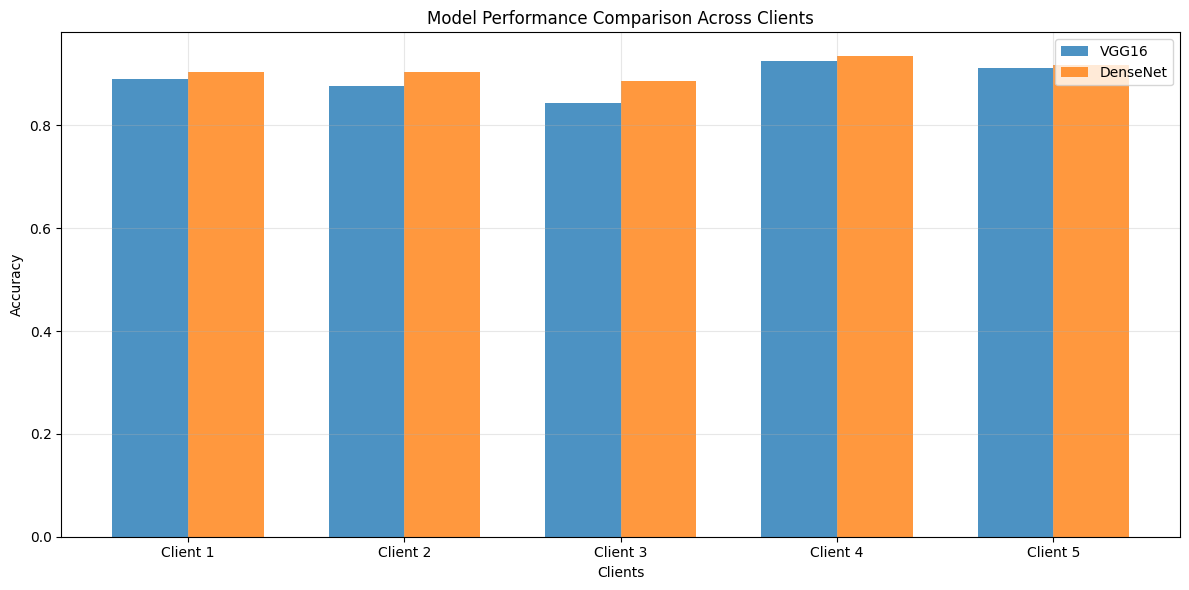

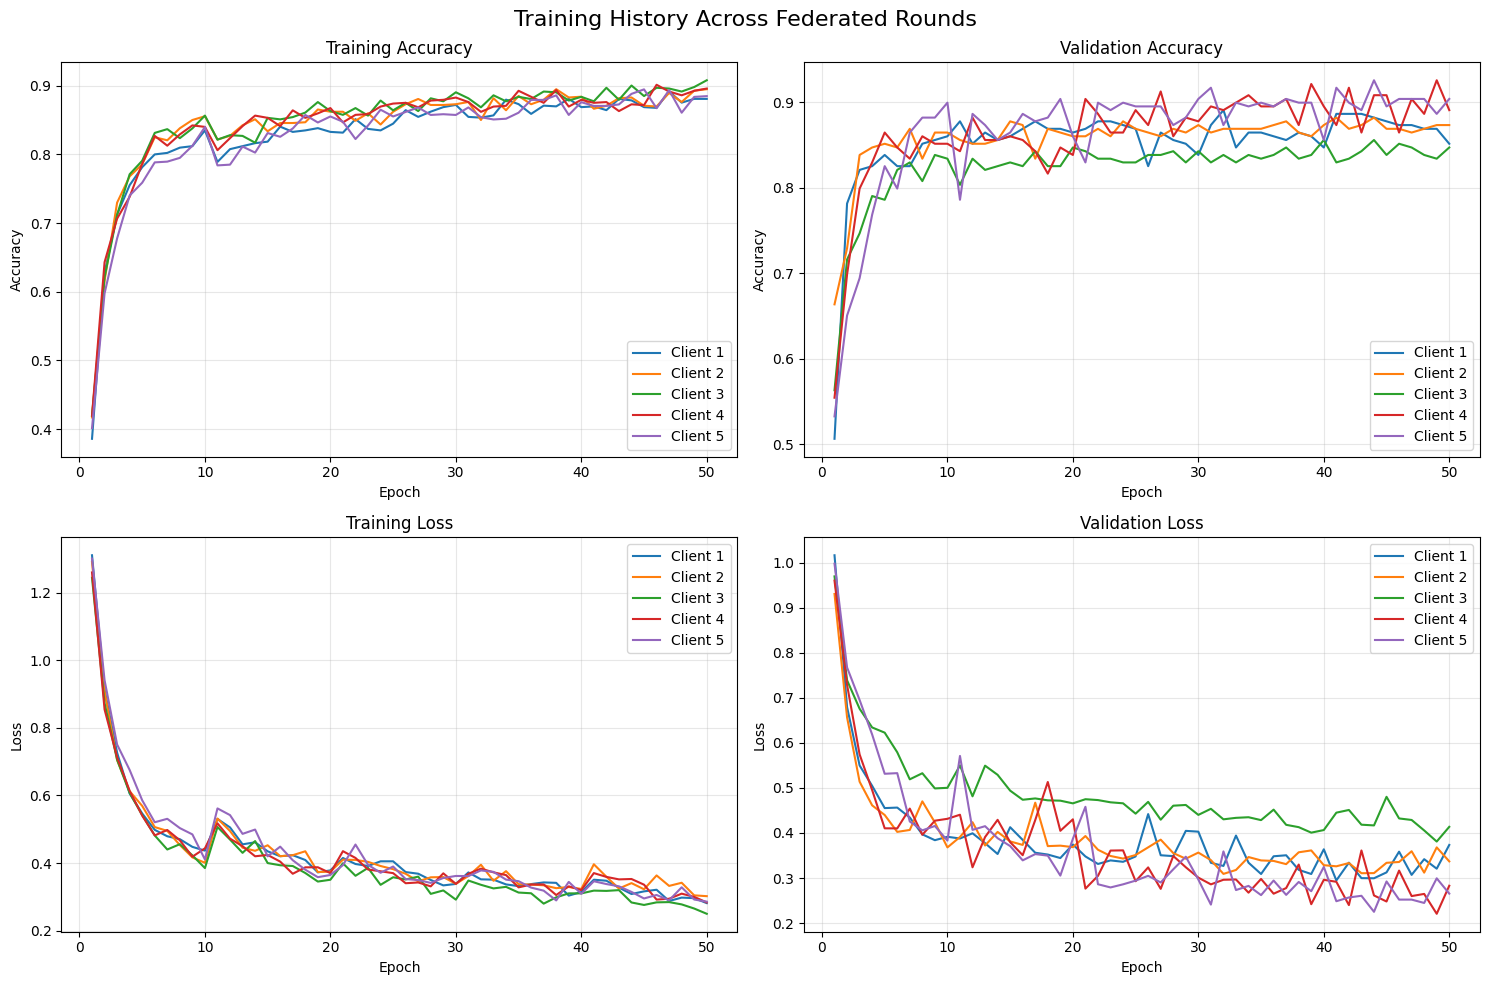

In [13]:
def compare_models():
    """
    Compare VGG16 and DenseNet performance across all clients
    """
    if not (fl_vgg16.client_data and fl_densenet.client_data):
        print("Both models need to be trained for comparison")
        return

    # Get results
    vgg16_results = fl_vgg16.evaluate_clients()
    densenet_results = fl_densenet.evaluate_clients()

    # Create comparison DataFrame
    comparison_data = []

    for client_id in vgg16_results.keys():
        if client_id in densenet_results:
            vgg16_acc = vgg16_results[client_id]['accuracy']
            densenet_acc = densenet_results[client_id]['accuracy']

            comparison_data.append({
                'Client': f'Client {client_id + 1}',
                'VGG16 Accuracy': vgg16_acc,
                'DenseNet Accuracy': densenet_acc,
                'Difference': densenet_acc - vgg16_acc
            })

    df_comparison = pd.DataFrame(comparison_data)

    print("\n" + "="*60)
    print("MODEL COMPARISON SUMMARY")
    print("="*60)
    print(df_comparison.round(4))

    # Calculate overall averages
    avg_vgg16 = df_comparison['VGG16 Accuracy'].mean()
    avg_densenet = df_comparison['DenseNet Accuracy'].mean()

    print(f"\nOverall Average Accuracies:")
    print(f"VGG16: {avg_vgg16:.4f}")
    print(f"DenseNet: {avg_densenet:.4f}")
    print(f"Difference: {avg_densenet - avg_vgg16:.4f}")

    # Plot comparison
    plt.figure(figsize=(12, 6))

    x = np.arange(len(df_comparison))
    width = 0.35

    plt.bar(x - width/2, df_comparison['VGG16 Accuracy'], width, label='VGG16', alpha=0.8)
    plt.bar(x + width/2, df_comparison['DenseNet Accuracy'], width, label='DenseNet', alpha=0.8)

    plt.xlabel('Clients')
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison Across Clients')
    plt.xticks(x, df_comparison['Client'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_training_history():
    """
    Plot training history for all clients
    """
    if not fl_vgg16.client_histories:
        print("No training history available")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History Across Federated Rounds', fontsize=16)

    for client_id, histories in fl_vgg16.client_histories.items():
        # Aggregate metrics across rounds
        all_acc = []
        all_val_acc = []
        all_loss = []
        all_val_loss = []

        for history in histories:
            all_acc.extend(history['accuracy'])
            all_val_acc.extend(history['val_accuracy'])
            all_loss.extend(history['loss'])
            all_val_loss.extend(history['val_loss'])

        epochs = range(1, len(all_acc) + 1)

        # Plot accuracy
        axes[0, 0].plot(epochs, all_acc, label=f'Client {client_id + 1}')
        axes[0, 1].plot(epochs, all_val_acc, label=f'Client {client_id + 1}')
        axes[1, 0].plot(epochs, all_loss, label=f'Client {client_id + 1}')
        axes[1, 1].plot(epochs, all_val_loss, label=f'Client {client_id + 1}')

    axes[0, 0].set_title('Training Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].set_title('Training Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].set_title('Validation Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run comparisons
compare_models()
plot_training_history()

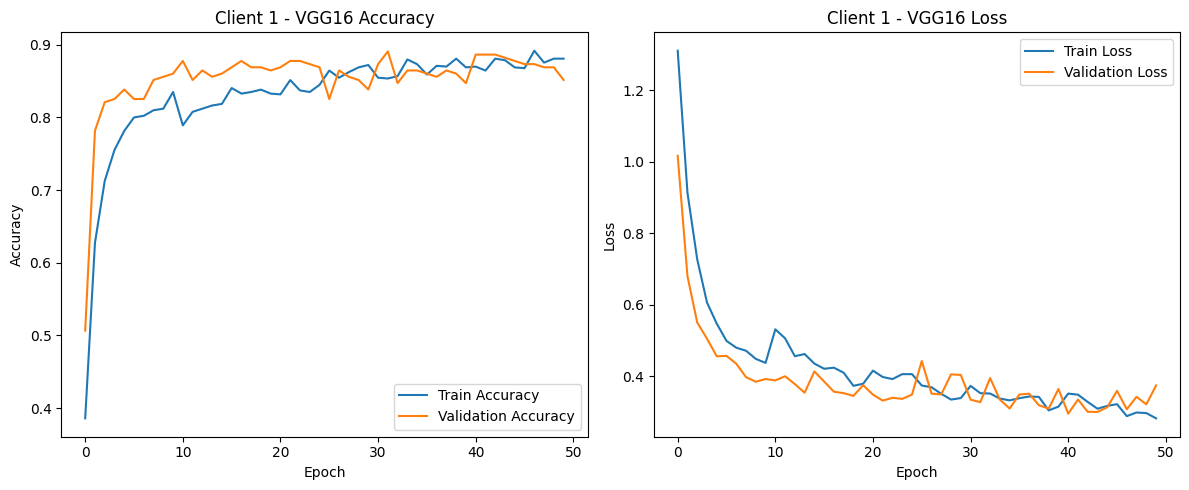

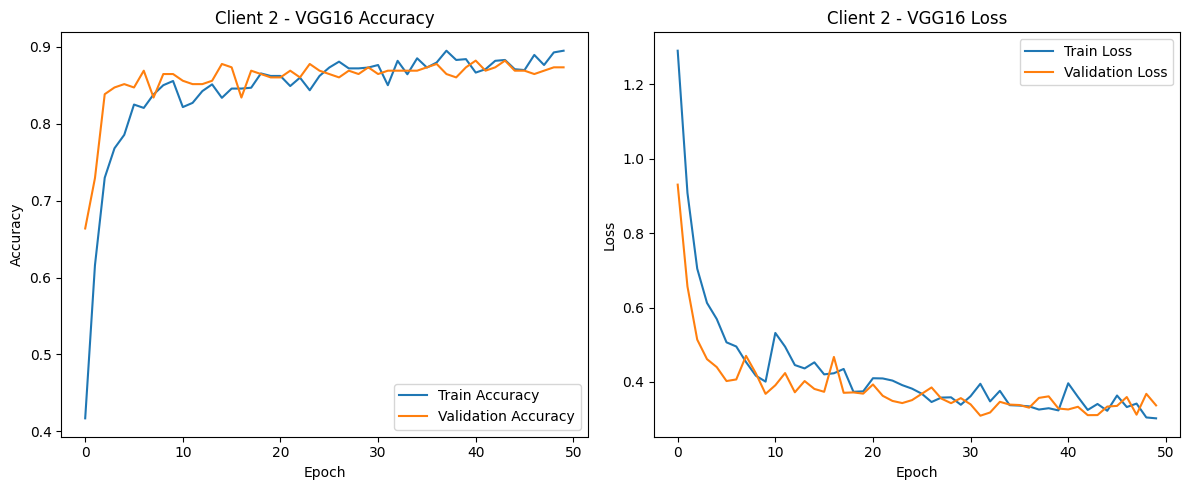

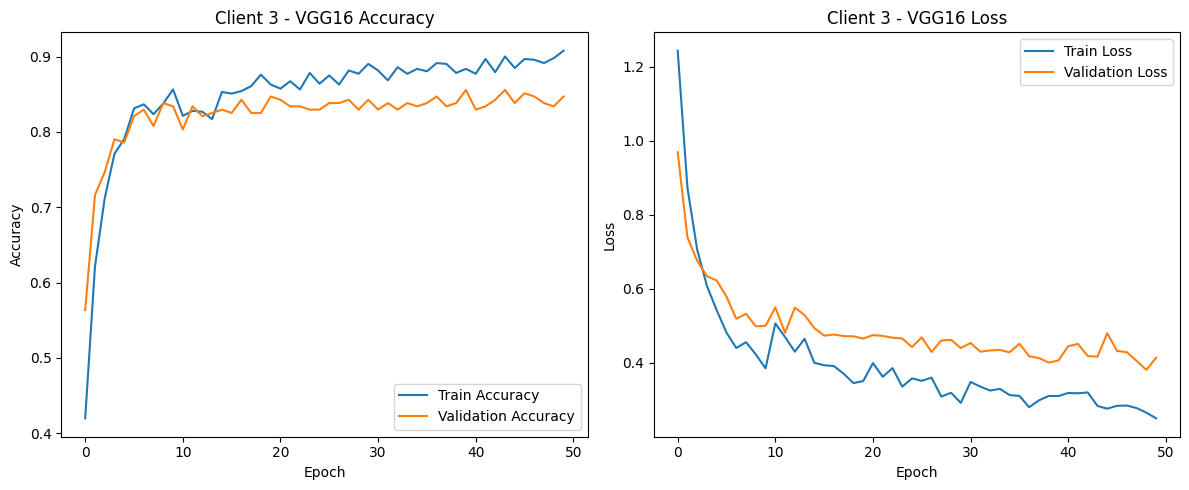

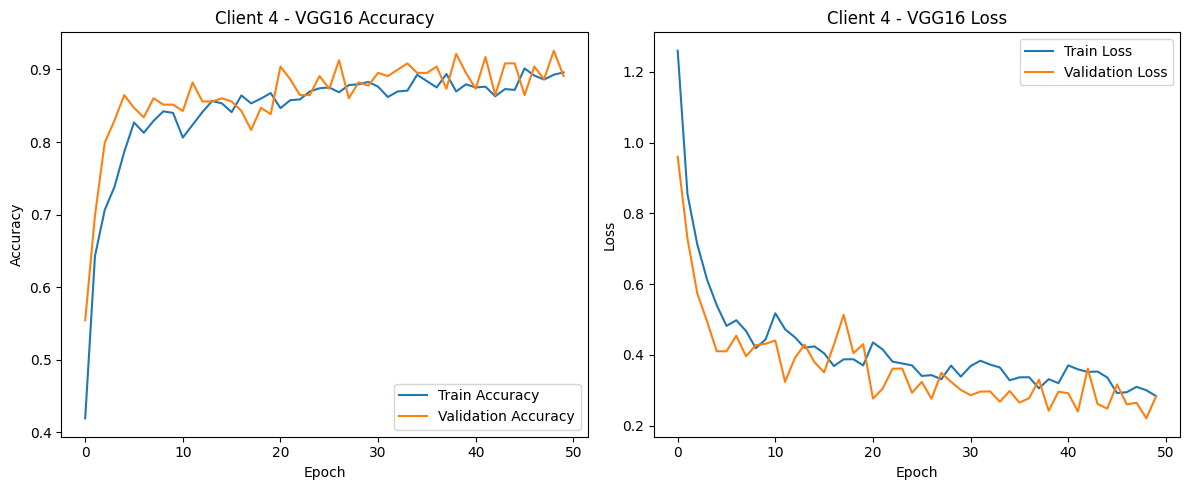

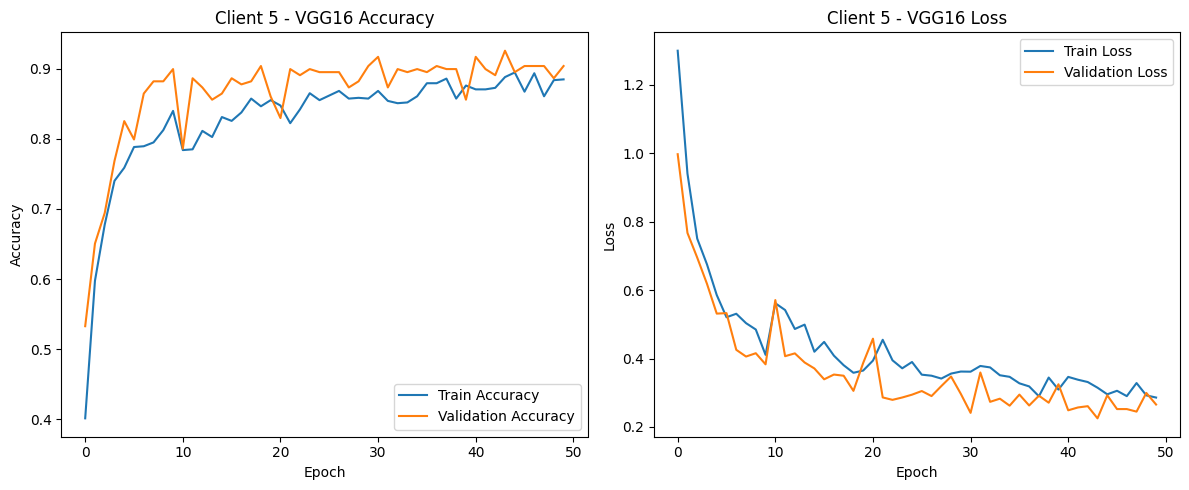

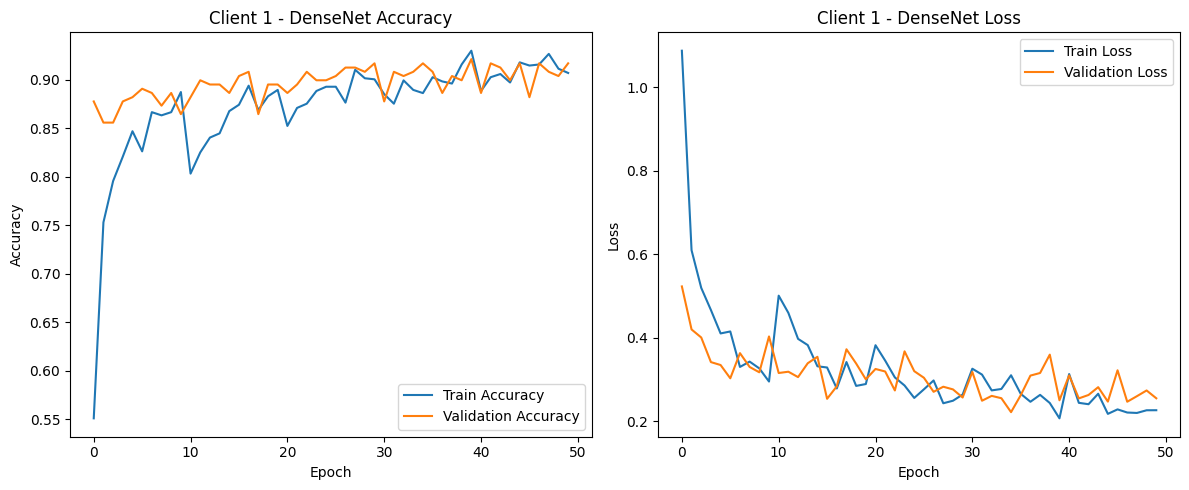

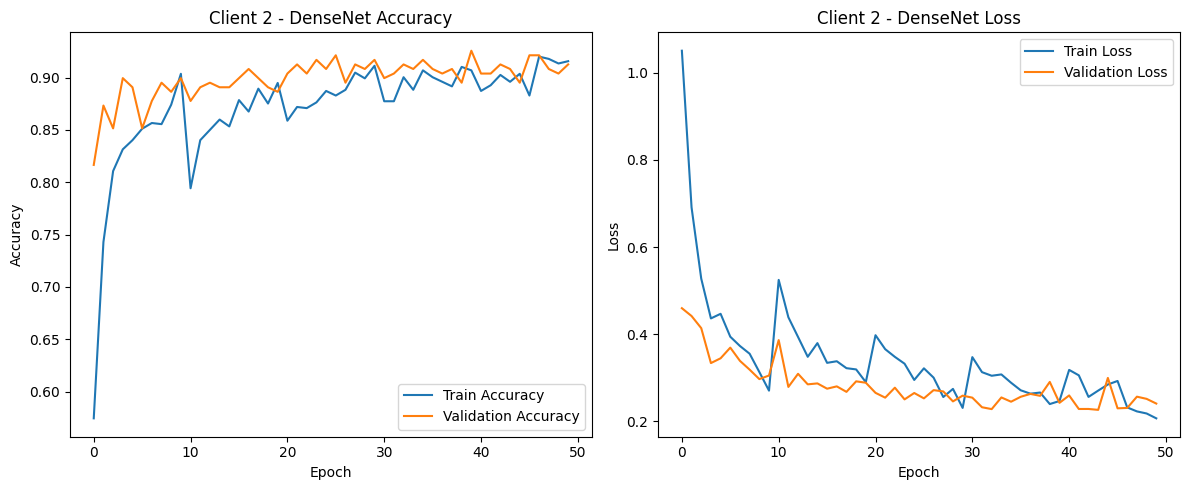

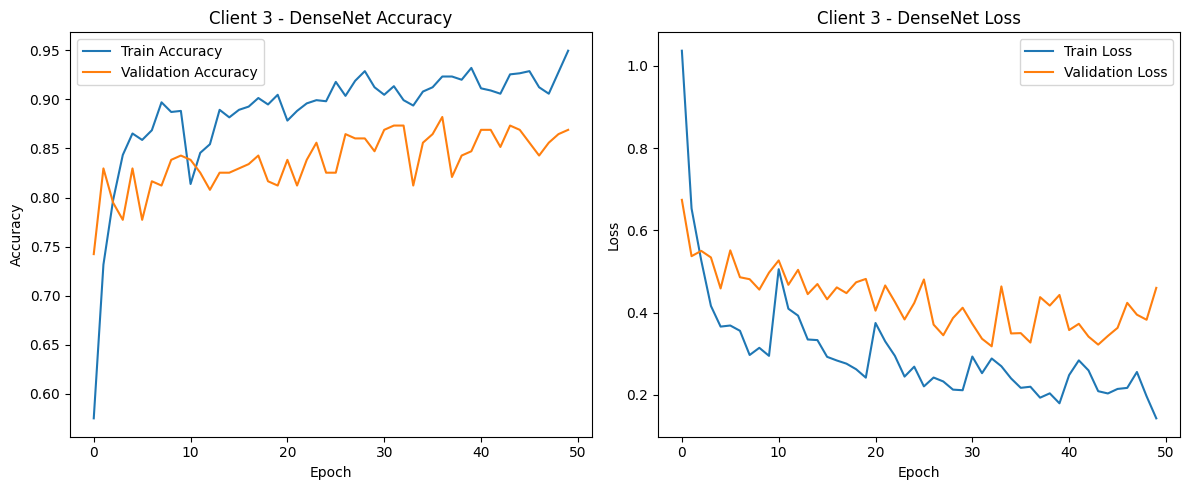

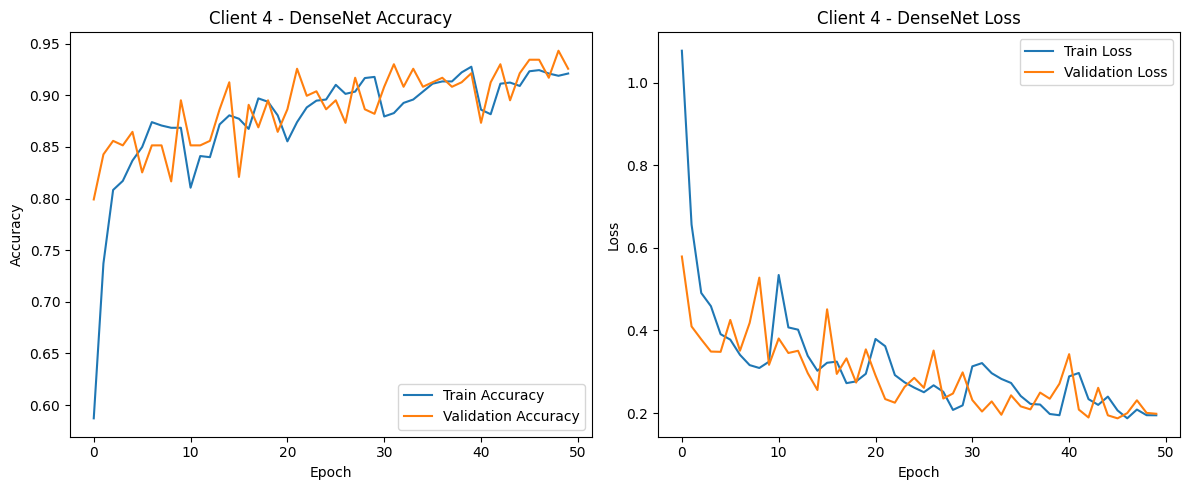

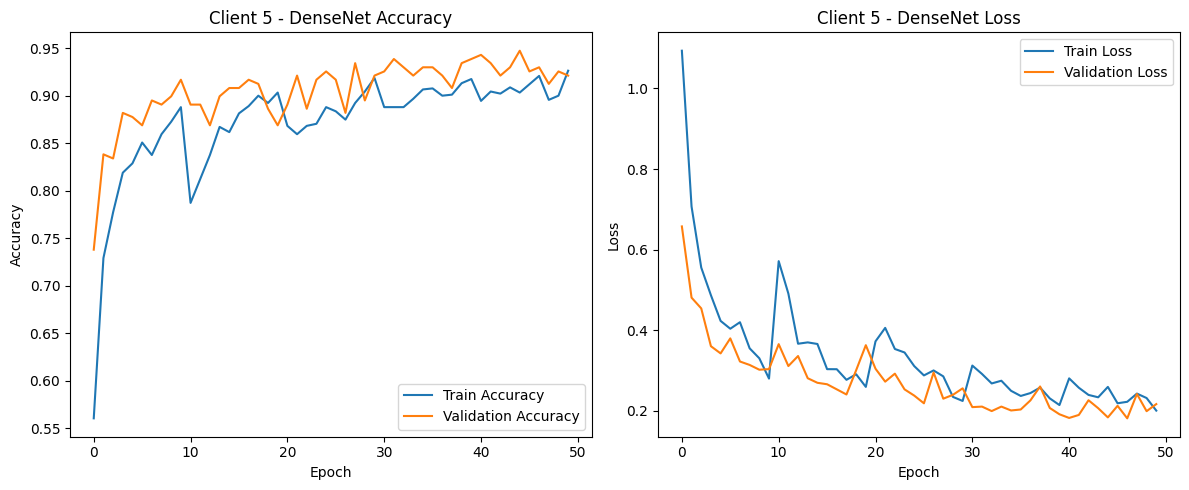

In [14]:
# Plot training and validation accuracy/loss for each client
import matplotlib.pyplot as plt

def plot_training_curves(client_histories, num_clients, model_name):
    for client_id in range(num_clients):
        if client_id not in client_histories:
            continue
        # Concatenate all rounds for this client
        acc = []
        val_acc = []
        loss = []
        val_loss = []
        for round_hist in client_histories[client_id]:
            acc.extend(round_hist.get('accuracy', []))
            val_acc.extend(round_hist.get('val_accuracy', []))
            loss.extend(round_hist.get('loss', []))
            val_loss.extend(round_hist.get('val_loss', []))
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Train Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.title(f'Client {client_id+1} - {model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Train Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.title(f'Client {client_id+1} - {model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Example usage after training:
plot_training_curves(fl_vgg16.client_histories, NUM_CLIENTS, 'VGG16')
plot_training_curves(fl_densenet.client_histories, NUM_CLIENTS, 'DenseNet')

## 12. Summary and Conclusions

In [15]:
def generate_final_summary():
    """
    Generate a comprehensive summary of the federated learning experiment
    """
    print("\n" + "="*80)
    print("FEDERATED LEARNING BRAIN TUMOR DETECTION - FINAL SUMMARY")
    print("="*80)

    print(f"\nExperiment Configuration:")
    print(f"- Number of Clients: {NUM_CLIENTS}")
    print(f"- Federated Rounds: {FEDERATED_ROUNDS}")
    print(f"- Epochs per Round: {EPOCHS_PER_ROUND}")
    print(f"- Image Size: {IMG_SIZE}")
    print(f"- Batch Size: {BATCH_SIZE}")
    print(f"- Learning Rate: {LEARNING_RATE}")
    print(f"- Classes: {CLASS_NAMES}")

    if fl_vgg16.client_data:
        print(f"\nDataset Statistics:")
        total_train = sum(len(data['X_train']) for data in fl_vgg16.client_data.values())
        total_test = sum(len(data['X_test']) for data in fl_vgg16.client_data.values())
        print(f"- Total Training Samples: {total_train}")
        print(f"- Total Testing Samples: {total_test}")
        print(f"- Samples per Client (avg): {total_train // len(fl_vgg16.client_data):.0f} train, {total_test // len(fl_vgg16.client_data):.0f} test")

    print(f"\nKey Features Implemented:")
    print(f"✓ Federated Learning with FedAvg algorithm")
    print(f"✓ VGG16 and DenseNet model architectures")
    print(f"✓ Image processing techniques (grayscaling, binarization, thresholding)")
    print(f"✓ Tumor region detection and segmentation")
    print(f"✓ Confusion matrices for each client")
    print(f"✓ Classification reports with precision, recall, F1-score")
    print(f"✓ Model performance comparison")
    print(f"✓ Training history visualization")
    print(f"✓ Google Colab compatibility")

    print(f"\nFederated Learning Benefits Demonstrated:")
    print(f"- Privacy preservation: Data remains on client devices")
    print(f"- Collaborative learning: Global model benefits from all clients")
    print(f"- Scalability: Easy to add more clients")
    print(f"- Robustness: Model trained on diverse data distributions")

    print(f"\nImage Processing Techniques Applied:")
    print(f"- Grayscale conversion for simplified analysis")
    print(f"- Binary thresholding using Otsu's method")
    print(f"- Morphological operations for noise reduction")
    print(f"- Edge detection using Canny algorithm")
    print(f"- Contour-based tumor region detection")

    if fl_vgg16.client_data and fl_densenet.client_data:
        vgg16_results = fl_vgg16.evaluate_clients()
        densenet_results = fl_densenet.evaluate_clients()

        vgg16_avg = np.mean([r['accuracy'] for r in vgg16_results.values()])
        densenet_avg = np.mean([r['accuracy'] for r in densenet_results.values()])

        print(f"\nFinal Model Performance:")
        print(f"- VGG16 Average Accuracy: {vgg16_avg:.4f}")
        print(f"- DenseNet Average Accuracy: {densenet_avg:.4f}")
        print(f"- Best Performing Model: {'DenseNet' if densenet_avg > vgg16_avg else 'VGG16'}")

    print(f"\nNext Steps and Improvements:")
    print(f"- Implement more advanced FL algorithms (FedProx, FedNova)")
    print(f"- Add differential privacy for enhanced security")
    print(f"- Experiment with different model architectures")
    print(f"- Implement client selection strategies")
    print(f"- Add real-time inference capabilities")
    print(f"- Deploy on edge devices for practical applications")

    print("\n" + "="*80)
    print("EXPERIMENT COMPLETED SUCCESSFULLY!")
    print("="*80)

# Generate final summary
generate_final_summary()


FEDERATED LEARNING BRAIN TUMOR DETECTION - FINAL SUMMARY

Experiment Configuration:
- Number of Clients: 5
- Federated Rounds: 5
- Epochs per Round: 10
- Image Size: (224, 224)
- Batch Size: 16
- Learning Rate: 0.001
- Classes: ['Glioma', 'Meningioma', 'Notumor', 'Pituitary']

Dataset Statistics:
- Total Training Samples: 4567
- Total Testing Samples: 1145
- Samples per Client (avg): 913 train, 229 test

Key Features Implemented:
✓ Federated Learning with FedAvg algorithm
✓ VGG16 and DenseNet model architectures
✓ Image processing techniques (grayscaling, binarization, thresholding)
✓ Tumor region detection and segmentation
✓ Confusion matrices for each client
✓ Classification reports with precision, recall, F1-score
✓ Model performance comparison
✓ Training history visualization
✓ Google Colab compatibility

Federated Learning Benefits Demonstrated:
- Privacy preservation: Data remains on client devices
- Collaborative learning: Global model benefits from all clients
- Scalability: E

## Instructions for Running on Google Colab

### 1. Data Upload
To run this notebook with your brain tumor datasets:

**Option A: Direct Upload**
1. Create the directory structure by uncommenting `create_sample_structure()` in cell 6
2. Upload your images to the respective folders:
   - `/content/client1/Glioma/`
   - `/content/client1/Meningioma/`
   - `/content/client1/Notumor/`
   - `/content/client1/Pituitary/`
   - (Repeat for client2, client3, client4, client5)

**Option B: Google Drive**
1. Upload your client folders to Google Drive
2. Update the `BASE_PATH` variable in cell 6
3. Mount Google Drive using the provided code

### 2. Running the Notebook
1. Run all cells in sequence
2. The notebook will automatically:
   - Install required dependencies
   - Load and preprocess your data
   - Train both VGG16 and DenseNet models using federated learning
   - Generate comprehensive evaluation reports
   - Display image processing visualizations
   - Compare model performances